In [1]:
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests

import tensorflow as tf
from tensorflow.keras.applications import mobilenet, resnet50
from tensorflow.keras.preprocessing import image as kimage
import tensorflow.keras.backend as K

In [2]:
%matplotlib inline

Cele [1000 de clase](https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/) peste care s-a facut clasificarea

In [12]:
# for Resnet50
_module = resnet50
nn = resnet50.ResNet50(weights='imagenet')

def reverse_preprocessing(x):
    return np.clip((x[0, ..., ::-1] + [123.68, 116.779, 103.939]), 0, 255) / 255

In [3]:
# for MobileNet (recomended)
_module = mobilenet
nn = mobilenet.MobileNet(weights='imagenet')

def reverse_preprocessing(x):
    return np.clip(x[0] / 2 + .5, 0, 1)

In [4]:
def load_image(img):
    if isinstance(img, str):
        if img.startswith('http'):
            resp = requests.get(img)
            img = BytesIO(resp.content)
            
        img = Image.open(img)
    
    x = kimage.img_to_array(img.resize((224, 224)))    
    x = np.expand_dims(x, axis=0)
    x = _module.preprocess_input(x)
    return x

def save_image(x, path, fmt=None):
    x = reverse_preprocessing(x)
    kimage.array_to_img(x)
    kimage.save_img(path, x, file_format=fmt)
    
def predict_file(model, img_path):
    x = load_image(img_path)
    
    preds = nn.predict(x)
    return preds
    
def visualize_noise(x):
    """
    RGB images have positive valued pixels, but computing the 
    difference of two images can produce negative values as well
    
    This function constructs a positive valued bitmap from image differences
    by substiting negative values with their complementary color and adding
    it on top. Complements are just the combination of the other two color channels
    """
    
    color_add = np.clip(x, 0, np.inf)
    color_sub = np.clip(x, -np.inf, 0) @ (np.eye(3) - 1)
    return color_add + color_sub

In [5]:
def ifgsm(nn, x, class_number, targeted=False, epochs=25, epsilon=.1):
    x_adv = x
    x_noise = np.zeros_like(x)
    target = K.one_hot(class_number, nn.output_shape[1])
    
    for i in range(epochs):
        # Get the loss and gradient of the loss wrt the inputs
        x_tens = tf.Variable(x_adv)
        with tf.GradientTape() as gtape:
            y = nn(x_tens)
            loss = K.categorical_crossentropy(target, tf.reshape(y, (-1, )))
            
        # Get the sign of the gradient
        grads = gtape.gradient(loss, x_tens)
        delta = K.sign(grads[0])
        
        # Perturb the image
        if not targeted:
            x_adv = x_adv + epsilon * delta
        else:
            x_adv = x_adv - epsilon * delta

        # Get the new image and predictions
        preds = nn.predict(x_adv, verbose=False)

        # Yield the adversarial example and the predictions of the model
        yield (i, x_adv, preds[0])

1/1 [==============================] - 0s 401ms/step


[[('n02510455', 'giant_panda', 0.9999373),
  ('n04254680', 'soccer_ball', 7.1465934e-06),
  ('n02093647', 'Bedlington_terrier', 4.8373568e-06),
  ('n02104029', 'kuvasz', 4.835636e-06),
  ('n04399382', 'teddy', 3.8904486e-06),
  ('n02509815', 'lesser_panda', 3.2517912e-06),
  ('n01855672', 'goose', 2.0582088e-06),
  ('n02113799', 'standard_poodle', 1.9051029e-06),
  ('n03045698', 'cloak', 1.731337e-06),
  ('n13044778', 'earthstar', 1.6859743e-06)]]

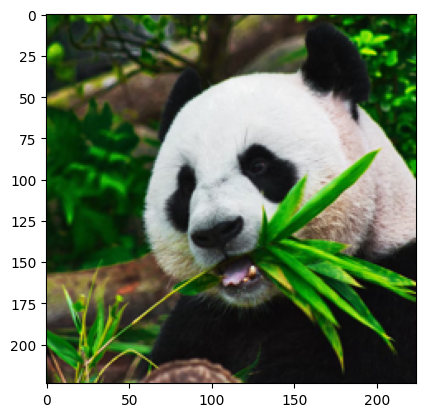

In [6]:
orig = load_image("images/panda.jpg")
plt.imshow(reverse_preprocessing(orig))


pred = nn.predict(orig)
_module.decode_predictions(pred, top=10)

In [9]:
initial_class = np.argmax(pred)
print('Original prediction:', pred[0, initial_class])

results = []
for i, adv, p in ifgsm(nn, orig, initial_class, targeted=False, epsilon=.1):
    results.append((adv, p))
    
    if i % 1 == 0:
        print(p[initial_class])
        
    if p[initial_class] < .0001:
        break

Original prediction: 0.9999373
0.037486117
9.77916e-07


[[('n02102318', 'cocker_spaniel', 0.3770472),
  ('n02102040', 'English_springer', 0.26714987),
  ('n04599235', 'wool', 0.03329871),
  ('n02102480', 'Sussex_spaniel', 0.023386378),
  ('n02102177', 'Welsh_springer_spaniel', 0.020851735)]]

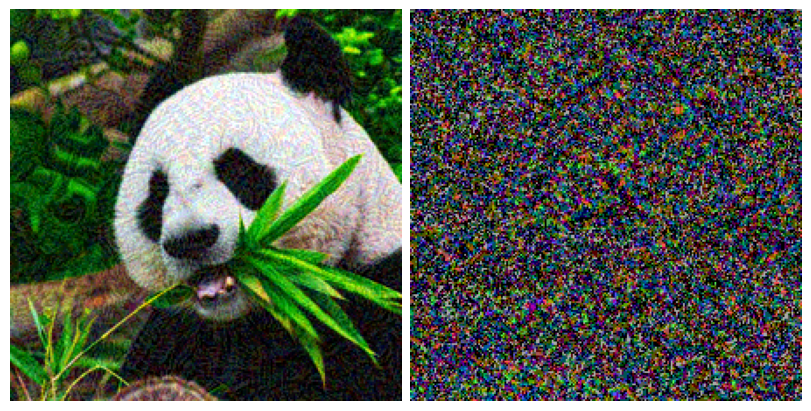

In [10]:
adv, p = results[-1]

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(8, 4), constrained_layout=True)
ax0.imshow(reverse_preprocessing(adv))
dx = visualize_noise((adv - orig).numpy().squeeze())
ax1.imshow(dx / dx.max())

for ax in (ax0, ax1):
    ax.grid('off')
    ax.axis('off')
    
_module.decode_predictions(p.reshape(1, -1))

In [13]:
target_class = 805
z = np.zeros((1, 1000))
z[0, target_class] = 1
print(_module.decode_predictions(z, top=1))

initial_class = np.argmax(pred)
print('Original'.ljust(20), 'Target')

results = []
for i, adv, p in ifgsm(nn, orig, target_class, targeted=True, epsilon=.1):
    results.append((adv, p))
    
    if i % 1 == 0:
        print(f'{p[initial_class]:<20.10} {p[target_class]:.10}')
        
    if p[initial_class] < .0001 and p[target_class] > .5:
        break

[[('n04254680', 'soccer_ball', 1.0)]]
Original             Target
0.3105588555         0.2165834904
3.421017993e-07      0.9997981191


[[('n04254680', 'soccer_ball', 0.9997981),
  ('n04118538', 'rugby_ball', 0.00011303209),
  ('n03598930', 'jigsaw_puzzle', 1.7879396e-05),
  ('n04120489', 'running_shoe', 1.3784566e-05),
  ('n03220513', 'dome', 6.9070784e-06),
  ('n04409515', 'tennis_ball', 3.7853763e-06),
  ('n02799071', 'baseball', 3.7700793e-06),
  ('n03724870', 'mask', 3.3097697e-06),
  ('n04259630', 'sombrero', 2.694164e-06),
  ('n03942813', 'ping-pong_ball', 2.1878432e-06),
  ('n04328186', 'stopwatch', 2.0634939e-06),
  ('n03590841', "jack-o'-lantern", 1.973062e-06),
  ('n02802426', 'basketball', 1.9304648e-06),
  ('n03840681', 'ocarina', 1.625991e-06),
  ('n04540053', 'volleyball', 1.4050752e-06),
  ('n02877765', 'bottlecap', 1.2533174e-06),
  ('n02843684', 'birdhouse', 1.1033001e-06),
  ('n02100735', 'English_setter', 1.0151019e-06),
  ('n03720891', 'maraca', 7.74338e-07),
  ('n02088238', 'basset', 7.283959e-07),
  ('n04026417', 'purse', 6.908643e-07),
  ('n02088364', 'beagle', 6.8482797e-07),
  ('n02988304', 'C

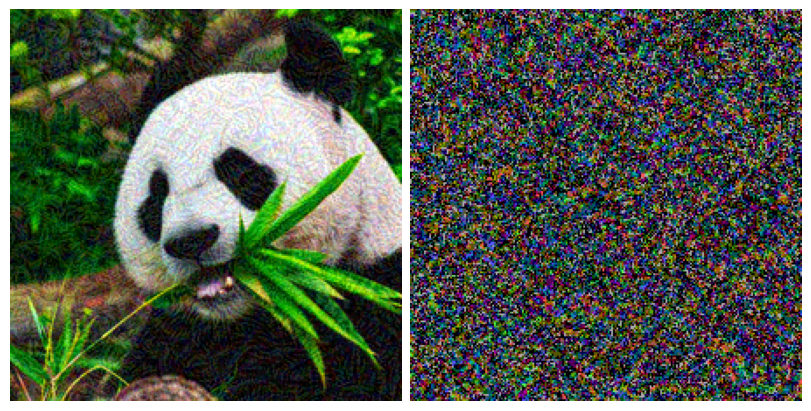

In [14]:
adv, p = results[-1]

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(8, 4), constrained_layout=True)
ax0.imshow(reverse_preprocessing(adv))
dx = visualize_noise((adv - orig).numpy().squeeze())
ax1.imshow(dx / dx.max())

for ax in (ax0, ax1):
    ax.grid('off')
    ax.axis('off')
    
_module.decode_predictions(p.reshape(1, -1), top=40)

In [15]:
# Attack will be affected by discretization and compression
for fmt in ['bmp', 'png', 'jpeg']:
    save_image(adv, f'adversarial.{fmt}', fmt=fmt)
    p = predict_file(nn, f'adversarial.{fmt}')
    
    print(fmt, _module.decode_predictions(p), '\n')

1/1 [==============================] - 0s 40ms/step
bmp [[('n04254680', 'soccer_ball', 0.99983215), ('n04118538', 'rugby_ball', 0.000107089494), ('n03598930', 'jigsaw_puzzle', 1.5343629e-05), ('n03220513', 'dome', 5.7206325e-06), ('n04120489', 'running_shoe', 5.701874e-06)]] 

1/1 [==============================] - 0s 39ms/step
png [[('n04254680', 'soccer_ball', 0.99983215), ('n04118538', 'rugby_ball', 0.000107089494), ('n03598930', 'jigsaw_puzzle', 1.5343629e-05), ('n03220513', 'dome', 5.7206325e-06), ('n04120489', 'running_shoe', 5.701874e-06)]] 

1/1 [==============================] - 0s 40ms/step
jpeg [[('n04254680', 'soccer_ball', 0.99957496), ('n04118538', 'rugby_ball', 0.00012756368), ('n02799071', 'baseball', 6.673684e-05), ('n02510455', 'giant_panda', 4.5407e-05), ('n02100735', 'English_setter', 2.922866e-05)]] 



# Gradient / Perturbation based Attcks

__(Iterative) Fast Gradient Sign Method__
- Se modifica pixelii cu $\pm\epsilon$ in funcție de semnul gradientului
- Perturbare limitată de pixelul cu deviație maximă ($L_\infty$)

__[DeepFool](https://towardsdatascience.com/deepfool-a-simple-and-accurate-method-to-fool-deep-neural-networks-17e0d0910ac0)__
- Se modifica pixelii in funcție de gradient cu pași calculați să treaca cel mai apropiat prag de decizie
- Perturbarea nu e limitată explicit, dar se descrie cel mai "scurt traseu" ($~L_2$)

__[Jacobian Saliency Attack](https://deepnotes.io/adversarial-attack#jacobian-based-saliency-map-attack)__
- Se modifică pixelii cei mai vulnerabili în ordine până se obtține exemplul adversar
- Perturbare limitată de numărul de pixeli modificați ($L_0$)

__[Carlini-Wagner Attack](https://medium.com/@iambibek/explanation-of-the-carlini-wagner-c-w-attack-algorithm-to-generate-adversarial-examples-6c1db8669fa2)__
- Procesul de perturbare nu e descris, ci doar mărimea ce se vrea a fi optimizată: $argmin_\delta (||\delta||_p + \alpha F(x+\delta))$
- Se determină ce compromis între perturbare și efectul asupra predicției ce ne dorim modificând $\alpha$